Riddler League Baseball, also known as the RLB, consists of three teams: the Mississippi Moonwalkers, the Delaware Doubloons and the Tennessee Taters.

Each time a batter for the Moonwalkers comes to the plate, they have a 40 percent chance of getting a walk and a 60 percent chance of striking out. Each batter for the Doubloons, meanwhile, hits a double 20 percent percent of the time, driving in any teammates who are on base, and strikes out the remaining 80 percent of the time. Finally, each batter for the Taters has a 10 percent chance of hitting a home run and a 90 percent chance of striking out.

During the RLB season, each team plays an equal number of games against each opponent. Games are nine innings long and can go into extra innings just like in other baseball leagues. Which of the three teams is most likely to have the best record at the end of the season?

https://fivethirtyeight.com/features/which-baseball-team-will-win-the-riddler-fall-classic/

In [1]:
# Import libraries
import numpy as np
from numpy.random import choice
import numpy.ma as ma

import matplotlib.style
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from itertools import zip_longest

In [2]:
# Game Logic


# handle_bases calculates the new status of baserunners 
# given the outcome of an at bat and a previous base runner state
# and returns the new base runner state and the number of runs scored

#on_base = [#is_on_first, #is_on_second, #is_on_third, #is_home]
def handle_bases(on_base, outcome, verbose):
    runs_scored = 0
    if (outcome == 0): #strikeout
        if(verbose > 0):
            print('strikeout')
        return [on_base, 0] # no one moves
    elif (outcome == 1): #walk, not forced runners don't advance
        if(verbose > 0):
            print('walk')
        for x in range(len(on_base)-2, -1, -1): # iterate over bases third -> second -> first
            if(sum(on_base[:x]) == x and on_base[x] == 1): # runner forced
                on_base[x+1] = 1 # advance
                on_base[x] = 0 # original base is now open
        runs_scored = on_base[3] # if anyone made it home, count the run
        if(runs_scored > 0):
             if(verbose > 0):
                print('run scored!')
        on_base[3] = 0 # reset our run counter
        on_base[0] = 1 # the batter took his base
    else: # a hit happened (single, double, triple, HR)
        if(verbose > 0):
            print('hit')
        # advance each runner by N bases where N is 1 - single, 2 - double, 3 - triple, 4 - HR
        for x in range(len(on_base)-2, -1, -1):
            if(x+outcome >= 3): # a runner scored
                if(on_base[x] == 1):
                    if(verbose > 0):
                        print('run_scored')
                    on_base[3] += 1
                    on_base[x] = 0
            else: # advance everyone who didn't score by N bases
                on_base[x+outcome] = on_base[x]
                on_base[x] = 0
        on_base[outcome-1] = 1 # the batter is safe on a base
        runs_scored = on_base[3] # count up the runs
        on_base[3] = 0 # reset run counter
    if(verbose > 0):
        print(on_base)
    return [on_base, runs_scored]

# at_bat controls the batting logic. It randomly selects an outcome based on the team's stats,
# and either counts a strikeout or calls the base running logic to calculate the base status and runs scored
def at_bat(team, on_base, verbose):
    is_out = 0
    run_scored = 0
    outcome = choice(range(0, 5), 1, p=team)[0]
    if (outcome == 0):
        if(verbose > 0):
            print('strikeout')
        is_out = 1
    else:
        [on_base, run_scored] = handle_bases(on_base, outcome, verbose)
    return [is_out, run_scored, on_base]

# This controls the game logic. There are nine innings (plus extra if needed). Two teams bat one after the other
# and the score and winner is tallied
def game(teams, verbose):
    score = [0, 0]
    inning = 1
    while True:
        if(verbose > 0):
            print("inning ", inning, " ----")
        outs = 0
        on_base = [0, 0, 0, 0]
        for i in range(0, 2):
            if(verbose > 0):
                print('Team ', i, ' at bat')
            while(outs<3):
                is_out, run_scored, on_base = at_bat(teams[i][0], on_base, verbose)
                outs += is_out
                score[i] += run_scored
                on_base = on_base
                if(verbose > 0):
                    print('outs: ', outs)
            outs = 0
            on_base = [0, 0, 0, 0]
        if(verbose > 0):    
            print('score: ', score)
        inning += 1
        if (inning > 9 and score != [0, 0]):
            break
    # Update the teams' records
    if(score[0] > score[1]):
        teams[0][1][0] += 1
        teams[1][1][1] += 1
    else:
        teams[0][1][1] += 1
        teams[1][1][0] += 1
        
    # Record the total runs scored for each team
    teams[0][2][0] += score[0]
    teams[1][2][0] += score[1]
            

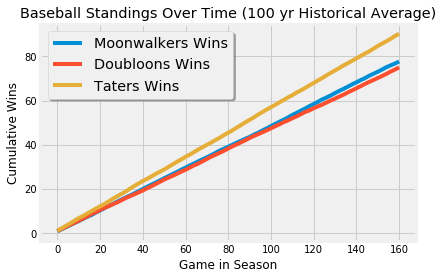

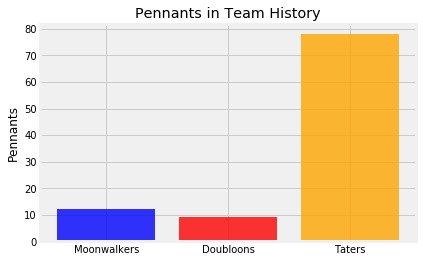

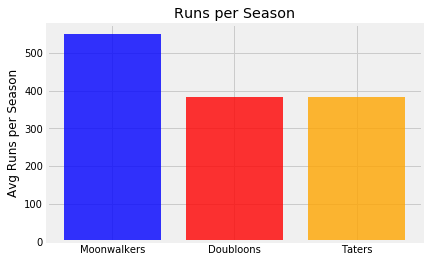

In [3]:
# This cell sets up our league. Right now there are 3 teams with different stats, and everyone starts with a 0-0 record
moonwalkers = [[0.6, 0.4, 0, 0, 0], [0, 0], [0]]
doubloons = [[0.8, 0, 0.2, 0,  0], [0, 0], [0]]
taters = [[0.9, 0, 0, 0, 0.1], [0, 0], [0]]

# initialize the wins in a season list, seasons in the team history list, and the number of pennants won by each team
# This can totally be made more efficient with np arrays or pd dataframes if we do many seasons
moonwalkers_wins_season = [0]
doubloons_wins_season = [0]
taters_wins_season = [0]
moonwalkers_wins_total = []
doubloons_wins_total = []
taters_wins_total = []
moonwalkers_runs_total = []
doubloons_runs_total = []
taters_runs_total = []
moonwalkers_rings = 0
doubloons_rings = 0
taters_rings = 0

# Each team plays twice in one "week", once against each other team. There are therefore 81 "weeks" in a season
weeks_in_season = 81
seasons = 100

for season in range(seasons):
    for week in range(weeks_in_season):
        game([moonwalkers, doubloons], 0)
        game([moonwalkers, taters], 0)
        game([taters, doubloons], 0)
        moonwalkers_wins_season.append(moonwalkers[1][0])
        doubloons_wins_season.append(doubloons[1][0])
        taters_wins_season.append(taters[1][0])
        
    if(moonwalkers[1][0] > doubloons[1][0] and moonwalkers[1][0] > taters[1][0]):
        moonwalkers_rings += 1
    elif(doubloons[1][0] > taters[1][0] and doubloons[1][0] > moonwalkers[1][0]):
        doubloons_rings += 1
    elif(taters[1][0] > doubloons[1][0] and taters[1][0] > moonwalkers[1][0]):
        taters_rings += 1
    moonwalkers_runs_total.append(moonwalkers[2])
    doubloons_runs_total.append(doubloons[2])
    taters_runs_total.append(doubloons[2])
    moonwalkers_wins_total.append(moonwalkers_wins_season)
    doubloons_wins_total.append(doubloons_wins_season)
    taters_wins_total.append(taters_wins_season)
    
    # reset for next year
    moonwalkers_wins_season = []
    doubloons_wins_season = []
    taters_wins_season = []
    moonwalkers = [[0.6, 0.4, 0, 0, 0], [0, 0], [0]]
    doubloons = [[0.8, 0, 0.2, 0,  0], [0, 0], [0]]
    taters = [[0.9, 0, 0, 0, 0.1], [0, 0], [0]]
    

# Calculate the average winrate by week over each team's history
moonwalkers_avg = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*moonwalkers_wins_total)][:-1]
doubloons_avg = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*doubloons_wins_total)][:-1]
taters_avg = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*taters_wins_total)][:-1]

wk_ax = range(weeks_in_season)

# Plot the season averaged win rate
fig, ax = plt.subplots()
ax.plot([2*x for x in wk_ax], moonwalkers_avg, label='Moonwalkers Wins')
ax.plot([2*x for x in wk_ax], doubloons_avg, label='Doubloons Wins')
ax.plot([2*x for x in wk_ax], taters_avg, label='Taters Wins')

plt.xlabel('Game in Season')
plt.ylabel('Cumulative Wins')
plt.title('Baseball Standings Over Time (100 yr Historical Average)')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

plt.show()

# plot the total number of pennants won by each team
teams = ('Moonwalkers', 'Doubloons', 'Taters')
y_pos = np.arange(len(teams))
championships = [moonwalkers_rings, doubloons_rings, taters_rings]

plt.bar(y_pos, championships, align='center', alpha=0.8, color=['blue', 'red', 'orange'])
plt.xticks(y_pos, teams)
plt.ylabel('Pennants')
plt.title('Pennants in Team History')

plt.show()

# plot the total number of runs by each team
teams = ('Moonwalkers', 'Doubloons', 'Taters')
y_pos = np.arange(len(teams))
runs = [np.mean(moonwalkers_runs_total), np.mean(doubloons_runs_total), np.mean(taters_runs_total)]

plt.bar(y_pos, runs, align='center', alpha=0.8, color=['blue', 'red', 'orange'])
plt.xticks(y_pos, teams)
plt.ylabel('Avg Runs per Season')
plt.title('Runs per Season')

plt.show()

The Taters absolutely crush over time. Looks like HRs matter quite a bit. But, it's not impossible for our underdogs to win a season